In [1]:
import numpy.random as npr
from numpy import linalg
import numpy as np
import matplotlib.pyplot as plt

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


The Covariance Matrix:
[[ 0.92061818  0.85878247  2.70001883]
 [ 0.85878247  8.85606254 10.57362748]
 [ 2.70001883 10.57362748 15.97366515]]


The EigenValues:
[2.38877480e+01 3.52716891e-16 1.86259790e+00]


The EigenVectores:
[[-0.11665994 -0.81649658  0.56544124]
 [-0.57586131 -0.40824829 -0.7083199 ]
 [-0.8091812   0.40824829  0.42256257]]


Now we use SVD:
The EigenValues:
[2.38877480e+01 1.86259790e+00 9.18387262e-16]


The EigenVectores:
[[-0.11665994  0.56544124 -0.81649658]
 [-0.57586131 -0.7083199  -0.40824829]
 [-0.8091812   0.42256257  0.40824829]]


Considering the eigenvalues obtained through the first method the principal components are:
E_Vaules[0] and E_Vaules[2]


The load of varaibility on the shoulders of first PCA:
0.9276670724994526


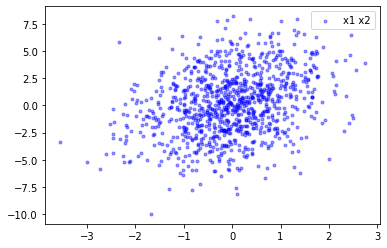

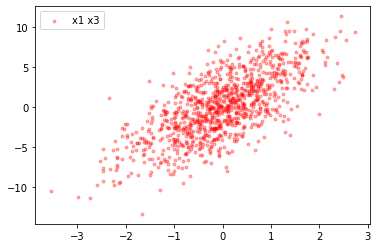

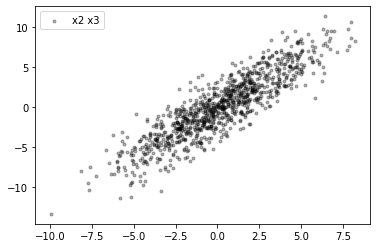

In [2]:
N=1000
mean= 0
std = 1

x1 = npr.normal(mean, std, N)

x2 = x1 + npr.normal(mean, 3*std, N)

x3 = 2*x1 + x2

Mat = np.array([x1, x2, x3])

Cov_Mat= np.cov(Mat)

print("The Covariance Matrix:")

print(Cov_Mat)
print("\n")

E_Values = linalg.eig(Cov_Mat)[0]

E_Vectors = linalg.eig(Cov_Mat)[1]

print("The EigenValues:")

print(E_Values)
print("\n")

print("The EigenVectores:")

print(E_Vectors)
print("\n")

print("Now we use SVD:")

U  = linalg.svd(Cov_Mat)[0]

Sp = linalg.svd(Cov_Mat)[1]

print("The EigenValues:")

print(Sp)
print("\n")

print("The EigenVectores:")

print(U)

print("\n")
print("Considering the eigenvalues obtained through the first method the principal components are:")
print("E_Vaules[0] and E_Vaules[2]")

print("\n")

print("The load of varaibility on the shoulders of first PCA:")

Load = E_Values[0]/np.sum(E_Values)

print(Load)

#Plotting the Data:
plt.scatter(x1,x2, label= 'x1 x2', color='blue', alpha=0.4, marker ='.')

plt.legend()

plt.figure()

plt.scatter(x1,x3, label= 'x1 x3', color='r', alpha=0.3, marker ='.' )

plt.legend()

plt.figure()

plt.scatter(x2,x3, label= 'x2 x3', color='0', alpha=0.3, marker ='.' )

plt.legend()

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

The Covariance Matrix:
[[ 9.20618182e-01  8.58782469e-01  2.70001883e+00 -2.38714060e-04
  -1.77174249e-04  1.44547212e-04  3.26468504e-04 -8.68151386e-04
  -9.29688964e-04 -4.14794368e-04  3.42402099e-04  1.59208341e-03
   2.62567035e-04]
 [ 8.58782469e-01  8.85606254e+00  1.05736275e+01  1.06623090e-03
  -3.90824185e-03  3.46229105e-03 -7.48950493e-04  9.22207382e-04
  -2.43159335e-03 -1.25899216e-03 -5.32540616e-04  1.48400930e-03
  -3.05330738e-03]
 [ 2.70001883e+00  1.05736275e+01  1.59736651e+01  5.88802781e-04
  -4.26259034e-03  3.75138547e-03 -9.60134850e-05 -8.14095391e-04
  -4.29097128e-03 -2.08858090e-03  1.52263582e-04  4.66817612e-03
  -2.52817331e-03]
 [-2.38714060e-04  1.06623090e-03  5.88802781e-04  3.98732644e-04
  -3.80897674e-06 -2.42699997e-05 -9.95162851e-06  5.90370785e-06
   1.69441927e-05  6.40375474e-06  2.45892815e-05  5.28580516e-06
  -2.24120048e-05]
 [-1.77174249e-04 -3.90824185e-03 -4.26259034e-03 -3.80897674e-06
   3.87132975e-04 -1.19456792e-05 -1.231988

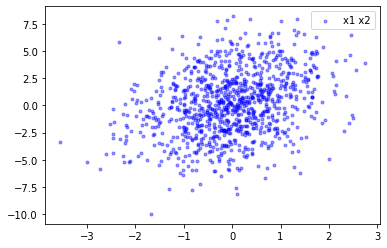

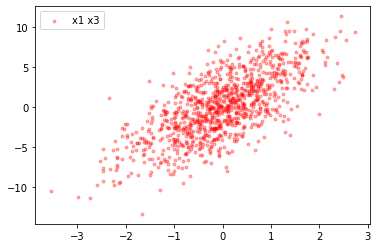

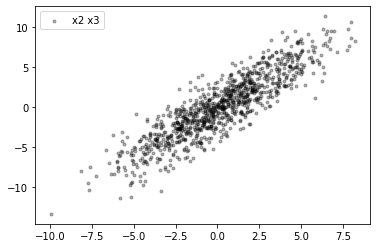

In [3]:
N=1000
mean= 0
std = 1

def NoiseGenerator_func():
    
    return npr.normal(mean, std/50 , N)

#We add 10 other variables to our Mat
New_variables = []

for i in range(10):
    
    New_variables.append(NoiseGenerator_func())

New_variables = np.array(New_variables)
    
#Now we concatanate the new variables to our former Mat
New_Mat = np.concatenate([Mat, New_variables], axis = 0)

Cov_Mat= np.cov(New_Mat)

print("The Covariance Matrix:")

print(Cov_Mat)
print("\n")

E_Values = linalg.eig(Cov_Mat)[0]

E_Vectors = linalg.eig(Cov_Mat)[1]

print("The EigenValues:")

print(E_Values)
print("\n")

print("The EigenVectores:")
print(E_Vectors)

print("\n")
print("Now we use SVD:")

U  = linalg.svd(Cov_Mat)[0]

Sp = linalg.svd(Cov_Mat)[1]

print("The EigenValues:")

print(Sp)
print("\n")

print("The EigenVectores:")

print(U)

print("\n")
print("Considering the new eigenvalues there seems to be just one principal component which is:")

print("E_Values[0]")

print(E_Values[0])


print("\n")
print("The load of varaibility on the shoulders of first PCA:")

Load = (E_Values[0])/(np.sum(E_Values))

print(Load)

#Plotting the Data:

plt.scatter(x1,x2, label= 'x1 x2', color='blue', alpha=0.4, marker ='.')

plt.legend()

plt.figure()

plt.scatter(x1,x3, label= 'x1 x3', color='r', alpha=0.3, marker ='.' )

plt.legend()

plt.figure()

plt.scatter(x2,x3, label= 'x2 x3', color='0', alpha=0.3, marker ='.' )

plt.legend()

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [4]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
